In [3]:
import sys

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from PIL import Image

sys.path.append('../src')
from data_utils import UnlearningDataLoader
import subprocess
import time
import warnings
from datetime import datetime

import mlflow
import torch
import torch.nn as nn
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import LambdaLR

from config import set_config
from data_utils import UnlearningDataLoader
from eval import (
    compute_accuracy,
    get_forgetting_rate,
    get_js_div,
    get_l2_params_distance,
    mia,
)
from mlflow_utils import mlflow_tracking_uri
from models import VGG19, AllCNN, ResNet18, ViT
from seed import set_seed
from unlearning_class import UnlearningClass
from sklearn.decomposition import PCA

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

/home/cspartalis/anaconda3/envs/MaUn/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# Args
run_id = "149b43f9c3414f889e9f768b79d729c2"
mlflow.set_tracking_uri(mlflow_tracking_uri)

In [5]:
# Setup
# Load params from retraining run
retrain_run = mlflow.get_run(run_id)
seed = int(retrain_run.data.params["seed"])
dataset = retrain_run.data.params["dataset"]
model_str = retrain_run.data.params["model"]
batch_size = int(retrain_run.data.params["batch_size"])
epochs_to_retrain = int(retrain_run.data.metrics["best_epoch"])
loss_str = retrain_run.data.params["loss"]
optimizer_str = retrain_run.data.params["optimizer"]
momentum = float(retrain_run.data.params["momentum"])
weight_decay = float(retrain_run.data.params["weight_decay"])
acc_forget_retrain = int(retrain_run.data.metrics["acc_forget"])

In [6]:
# Load data
UDL = UnlearningDataLoader(dataset, batch_size, seed)
dl, dataset_sizes = UDL.load_data()
num_classes = len(UDL.classes)
input_channels = UDL.input_channels
image_size = UDL.image_size

Files already downloaded and verified
Files already downloaded and verified


In [7]:
# Load model architecture
if model_str == "resnet18":
    model = ResNet18(input_channels, num_classes)
elif model_str == "allcnn":
    model = AllCNN(input_channels, num_classes)
elif model_str == "vgg19":
    model = VGG19(input_channels, num_classes)
elif model_str == "vit":
    model = ViT(image_size=image_size, num_classes=num_classes)
else:
    raise ValueError("Model not supported")
# Load the original model
model = mlflow.pytorch.load_model(f"{retrain_run.info.artifact_uri}/original_model")
model.to(DEVICE)
# Load the retrained model (is needed for js_div, l2_params_distance, and mia)
retrained_model = mlflow.pytorch.load_model(
    f"{retrain_run.info.artifact_uri}/retrained_model"
)
retrained_model.to(DEVICE)

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (identity_conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, m

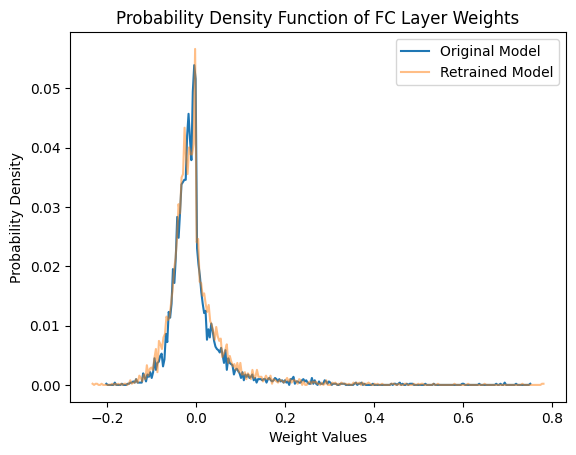

In [28]:
# # Get the weights of the fc layer
fc_weights = model.fc.weight.detach().cpu().numpy()
r_fc_weights = retrained_model.fc.weight.detach().cpu().numpy()

# Compute the histogram
hist_o, bin_edges_o = np.histogram(fc_weights, bins=300, density=True)
hist_r, bin_edges_r = np.histogram(r_fc_weights, bins=300, density=True)

# Calculate the bin width
bin_width_o = bin_edges_o[1] - bin_edges_o[0]
bin_width_r = bin_edges_r[1] - bin_edges_r[0]

# Normalize to get the PDF
pdf_values_o = hist_o / np.sum(hist_o)
pdf_values_r = hist_r / np.sum(hist_r)

# Plot the PDF
plt.plot(bin_edges_o[:-1], pdf_values_o, label='Original Model', alpha=1)
plt.plot(bin_edges_r[:-1], pdf_values_r, label='Retrained Model', alpha=0.5)
plt.title('Probability Density Function of FC Layer Weights')
plt.xlabel('Weight Values')
plt.ylabel('Probability Density')
plt.legend()
plt.show()


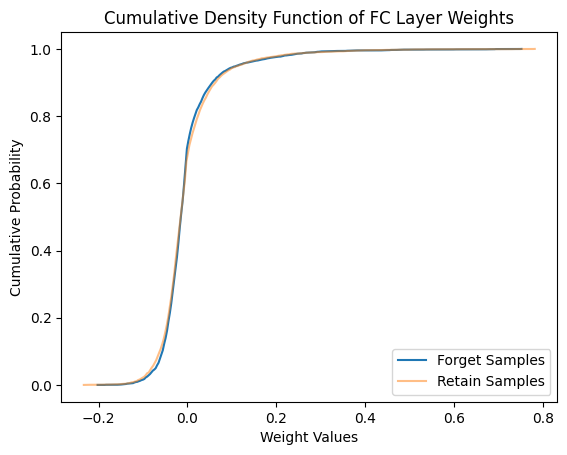

In [29]:
# Plot the CDF
cdf_values_o = np.cumsum(pdf_values_o)
cdf_values_r = np.cumsum(pdf_values_r)
plt.plot(bin_edges_o[:-1], cdf_values_o, label='Forget Samples')
plt.plot(bin_edges_r[:-1], cdf_values_r, label='Retain Samples', alpha=0.5)
plt.title('Cumulative Density Function of FC Layer Weights')
plt.xlabel('Weight Values')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()

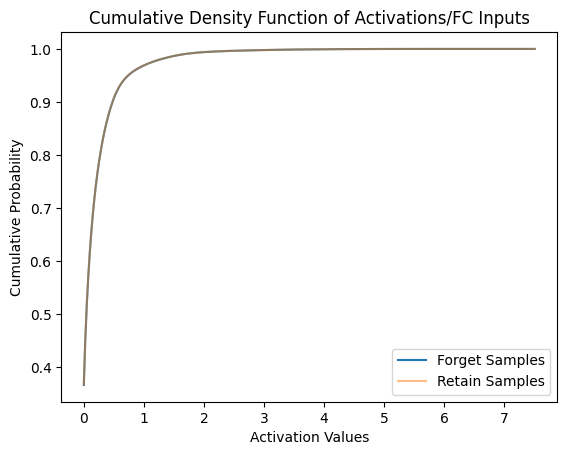

In [30]:

# Define a hook function to get the activations
def get_activations_hook(module, input, output):
    activations = input[0].cpu().detach().numpy().astype(np.float16)
    activations_hook.append(activations)

# Register the hook function to the FC layer
activations_hook = []
model.fc.register_forward_hook(get_activations_hook)

# Get the activations from the previous layer for forget samples
activations_f = []
num_samples = len(dl["forget"].dataset)
for i, (inputs, _) in enumerate(dl["forget"]):
    inputs = inputs.to(DEVICE)
    _ = model(inputs)
    activations_f.extend(activations_hook)

model.fc._forward_hooks.clear()

activations_f = np.concatenate(activations_f)
activations_f = activations_f.flatten()

# Get the activations from the previous layer for retain samples
activations_r = []
for i, (inputs, _) in enumerate(dl["retain"]):
    if i >= num_samples:
        break
    inputs = inputs.to(DEVICE)
    _ = model(inputs)
    activations_r.extend(activations_hook)

activations_r = np.concatenate(activations_r)
activations_r = activations_r.flatten()

# Compute the histogram
hist_f, bin_edges_f = np.histogram(activations_f, bins=300, density=True)
hist_r, bin_edges_r = np.histogram(activations_r, bins=300, density=True)

# Calculate the bin width
bin_width_f = bin_edges_f[1] - bin_edges_f[0]
bin_width_r = bin_edges_r[1] - bin_edges_r[0]

# Normalize to get the PDF
pdf_values_f = hist_f / np.sum(hist_f)
pdf_values_r = hist_r / np.sum(hist_r)

# Plot the CDF
cdf_values_f = np.cumsum(pdf_values_f)
cdf_values_r = np.cumsum(pdf_values_r)
plt.plot(bin_edges_f[:-1], cdf_values_f, label='Forget Samples')
plt.plot(bin_edges_r[:-1], cdf_values_r, label='Retain Samples', alpha=0.5)
plt.title('Cumulative Density Function of Activations/FC Inputs')
plt.xlabel('Activation Values')
plt.ylabel('Cumulative Probability')
plt.legend()
plt.show()




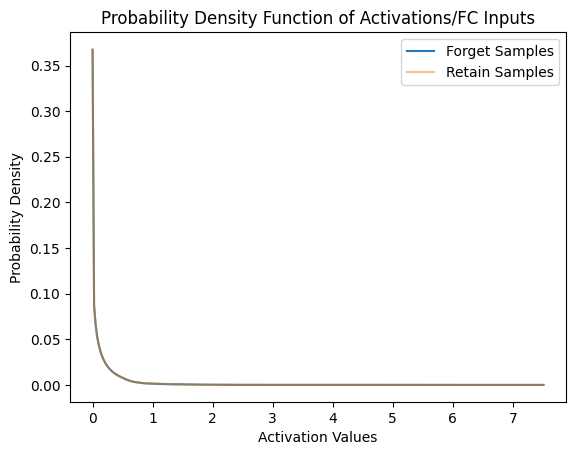

In [31]:
plt.plot(bin_edges_f[:-1], pdf_values_f, label='Forget Samples', alpha=1)
plt.plot(bin_edges_r[:-1], pdf_values_r, label='Retain Samples', alpha=0.5)
plt.title('Probability Density Function of Activations/FC Inputs')
plt.xlabel('Activation Values')
plt.ylabel('Probability Density')
plt.legend()
plt.show()